In [3]:
BASE_DIRECTORY = '/content/drive/MyDrive/NLP/ENG/Jigsaw1/'
DATA_DIRECTORY = BASE_DIRECTORY + 'input/'
MODEL_DIRECTORY = BASE_DIRECTORY + 'model/'
OUTPUT_DIRECTORY = BASE_DIRECTORY + 'output/'

# 0. Import library

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import log_loss, confusion_matrix, classification_report, roc_curve, auc

import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from scipy import sparse

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
%matplotlib inline
seed = 2390 

# 1. Read data set

In [8]:
train = pd.read_csv(DATA_DIRECTORY + 'train.csv')
test = pd.read_csv(DATA_DIRECTORY + 'test.csv')
print(f'Number of rows and columns in the train data set: {train.shape}')
print(f'Number of rows and columns in the test data set: {test.shape}')

Number of rows and columns in the train data set: (159571, 8)
Number of rows and columns in the test data set: (153164, 2)


In [9]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [10]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


# 2. Target variable distribution

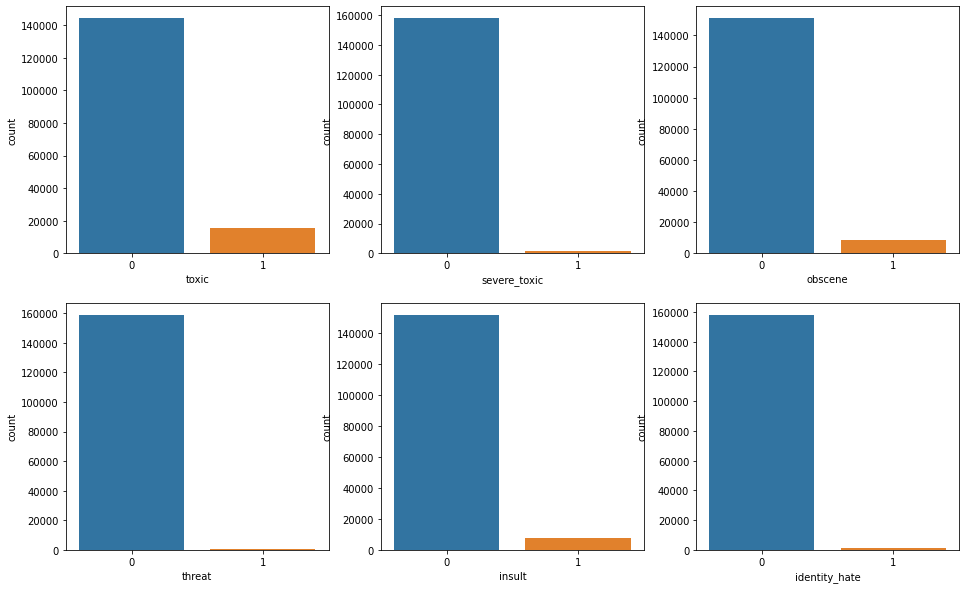

In [13]:
fig, ax = plt.subplots(2, 3, figsize=(16, 10))
ax1, ax2, ax3, ax4, ax5, ax6 = ax.flatten()
sns.countplot(train.toxic, ax=ax1)
sns.countplot(train.severe_toxic, ax=ax2)
sns.countplot(train.obscene, ax=ax3)
sns.countplot(train.threat, ax=ax4)
sns.countplot(train.insult, ax=ax5)
sns.countplot(train.identity_hate, ax=ax6)

In [15]:
train[train.identity_hate==1].comment_text

42        You are gay or antisemmitian? \n\nArchangel WH...
105              A pair of jew-hating weiner nazi schmucks.
176       I think that your a Fagget get a oife and burn...
218       Kill all niggers. \n\nI have hard, that others...
238       u r a tw@ fuck off u gay boy.U r smelly.Fuck u...
                                ...                        
159281    LoL!! \n\nyou're GAY!! you will never know how...
159336    Oh, fuck off. The pansy Jew would just whine a...
159400    Shalom \n\nSemite, get the fuck out of here. I...
159449                           I think he is a gay fag!!!
159494    "\n\n our previous conversation \n\nyou fuckin...
Name: comment_text, Length: 1405, dtype: object

# 3. Missing value

In [16]:
k = pd.DataFrame()
k['train'] = train.isnull().sum()
k['test'] = test.isnull().sum()
k

,train,test
id,0,0.0
comment_text,0,0.0
toxic,0,NaN
severe_toxic,0,NaN
obscene,0,NaN
threat,0,NaN
insult,0,NaN
identity_hate,0,NaN


In [17]:
test[test.comment_text.isnull()]

,id,comment_text


In [19]:
test.fillna(' ', inplace=True)
gc.collect()

756

# 4. Text preprocessing

In [70]:
vect_word = TfidfVectorizer(max_features=10000, lowercase=True, analyzer='word', 
                            stop_words='english', ngram_range=(1, 2), dtype=np.float32)
vect_char = TfidfVectorizer(max_features=30000, lowercase=True, analyzer='char', 
                            stop_words='english', ngram_range=(1, 6), dtype=np.float32)

In [71]:
# vect_word.fit(list(train[comment_text']) +list(test['commen_text']))
tr_vect = vect_word.fit_transform(train.comment_text)
ts_vect = vect_word.transform(test.comment_text)

# vect_char.fit(list(train[comment_text']) +list(test['commen_text']))
tr_vect_char = vect_char.fit_transform(train.comment_text)
ts_vect_char = vect_char.transform(test.comment_text)

gc.collect()

2219

In [72]:
print(tr_vect.shape)
print(ts_vect.shape)
print(tr_vect_char.shape)
print(ts_vect_char.shape)

(159571, 10000)
(153164, 10000)
(159571, 30000)
(153164, 30000)


In [73]:
X = sparse.hstack([tr_vect, tr_vect_char])
X_test = sparse.hstack([ts_vect, ts_vect_char])

In [74]:
X.shape

(159571, 40000)

In [75]:
X.shape, X_test.shape

((159571, 40000), (153164, 40000))

In [76]:
# X = tr_vect
target_col = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']
y = train[target_col]

# x_test = ts_vect
# del tr_vect, ts_vect, tr_vect_char, ts_vect_char
gc.collect()

0

# 5. Model

In [77]:
prd = np.zeros((X_test.shape[0],y.shape[1]))
cv_score =[]
for i,col in enumerate(target_col):
    lr = LogisticRegression(C=4,random_state = i)
    print('Building {} model for column:{''}'.format(i,col)) 
    lr.fit(X,y[col])
    #cv_score.append(lr.score)
    prd[:,i] = lr.predict_proba(X_test)[:,1]

Building 0 model for column:toxic


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Building 1 model for column:severe_toxic


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Building 2 model for column:obscene


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Building 3 model for column:threat
Building 4 model for column:insult


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Building 5 model for column:identity_hate


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


# 6. Model Validation on train data set

In [78]:
col = 'identity_hate'
print('Column:', col)
pred = lr.predict(X)
print('\n Confusion matrix\n', confusion_matrix(y[col], pred))
print(classification_report(y[col], pred))

Column: identity_hate

 Confusion matrix
 [[158075     91]
 [   675    730]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    158166
           1       0.89      0.52      0.66      1405

    accuracy                           1.00    159571
   macro avg       0.94      0.76      0.83    159571
weighted avg       0.99      1.00      0.99    159571



# 6. Roc AUC curve

Column: identity_hate


Text(0.5, 1.0, 'Reciever Operating Characteristic')

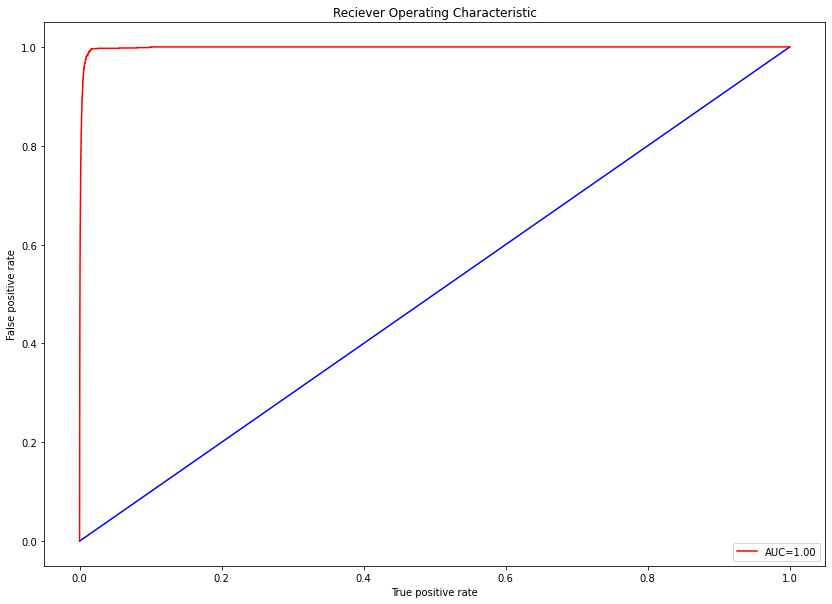

In [79]:
col = 'identity_hate'
print('Column:', col)
pred_pro = lr.predict_proba(X)[:, 1]
frp, trp, thres = roc_curve(y[col], pred_pro)
auc_val = auc(frp, trp)
plt.figure(figsize=(14, 10))
plt.plot([0,1],[0,1],color='b')
plt.plot(frp, trp, color='r', label=f'AUC={auc_val:.2f}')
plt.legend(loc='lower right')
plt.xlabel('True positive rate')
plt.ylabel('False positive rate')
plt.title('Reciever Operating Characteristic')

In [81]:
prd_1 = pd.DataFrame(prd, columns=y.columns)
submit = pd.concat([test['id'], prd_1], axis=1)
submit.to_csv(OUTPUT_DIRECTORY+'toxic_lr.csv', index=False)
submit.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.999997,0.323955,0.999985,0.087496,0.987176,0.665149
1,0000247867823ef7,0.003234,0.001577,0.000825,0.000106,0.002812,0.001204
2,00013b17ad220c46,0.004779,0.001376,0.005795,0.000076,0.001815,0.000686
3,00017563c3f7919a,0.002318,0.001310,0.000880,0.000257,0.001079,0.000091
4,00017695ad8997eb,0.007977,0.001406,0.001349,0.000361,0.007995,0.000405


In [82]:
!kaggle competitions submit -c jigsaw-toxic-comment-classification-challenge -f /content/drive/MyDrive/NLP/ENG/Jigsaw1/output/toxic_lr.csv -m "try1_tfidf_lr"

100% 21.2M/21.2M [00:02<00:00, 8.60MB/s]
Successfully submitted to Toxic Comment Classification Challenge